#### 1. Load data correctly and show contents in a cell
I load the data in steps.
1. Get the image and annotation names.
2. Convert images to Pytorch tensors and annotate them

In [1]:
# Download the VisDrone 2019 Dataset (3 GB)
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn" -O VisDrone2019-DET-train.zip && rm -rf /tmp/cookies.txt

In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# utils contains a bunch of functions I defined to help preprocess the data
import utils

In [3]:
np.random.seed(0)

# get image names
n = 500 # Note: only using 500/6471 images temporarily for testing (otherwise notebook will take too long to run, or I run out of RAM)
dataset_dir = 'VisDrone2019-DET-train'
dataset_names = utils.get_names(dataset_dir , n)


# get image and annotation paths
X_path = [os.path.join(dataset_dir,'images',name+".jpg") for name in dataset_names]
y_path = [os.path.join(dataset_dir,'annotations',name+".txt") for name in dataset_names]
print('First 10 image paths:')
print(X_path[0:10])
print('First 10 annotation paths:')
print(y_path[0:10])

First 10 image paths:
['VisDrone2019-DET-train\\images\\9999969_00000_d_0000021.jpg', 'VisDrone2019-DET-train\\images\\9999956_00000_d_0000098.jpg', 'VisDrone2019-DET-train\\images\\9999945_00000_d_0000155.jpg', 'VisDrone2019-DET-train\\images\\0000076_00004_d_0000001.jpg', 'VisDrone2019-DET-train\\images\\0000334_02549_d_0000034.jpg', 'VisDrone2019-DET-train\\images\\9999962_00000_d_0000092.jpg', 'VisDrone2019-DET-train\\images\\9999982_00000_d_0000100.jpg', 'VisDrone2019-DET-train\\images\\9999984_00000_d_0000037.jpg', 'VisDrone2019-DET-train\\images\\9999999_00841_d_0000384.jpg', 'VisDrone2019-DET-train\\images\\9999982_00000_d_0000080.jpg']
First 10 annotation paths:
['VisDrone2019-DET-train\\annotations\\9999969_00000_d_0000021.txt', 'VisDrone2019-DET-train\\annotations\\9999956_00000_d_0000098.txt', 'VisDrone2019-DET-train\\annotations\\9999945_00000_d_0000155.txt', 'VisDrone2019-DET-train\\annotations\\0000076_00004_d_0000001.txt', 'VisDrone2019-DET-train\\annotations\\0000334_0

First image:


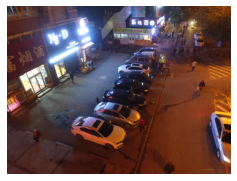

First annotation:
387,408,40,82,1,1,0,0
828,697,42,91,1,1,0,0
973,971,77,79,1,1,1,0
1186,460,50,81,1,1,0,0
1154,336,33,75,1,1,0,0
935,359,22,69,1,1,0,0
911,325,15,62,1,1,0,0
921,341,17,68,1,1,0,0
1037,258,23,59,1,1,0,0
1072,254,15,61,1,1,0,0
1088,257,17,55,1,1,0,0
1113,290,14,42,1,1,0,0
1117,254,25,55,1,1,0,1
1163,256,23,51,1,1,0,0
1205,246,26,60,1,10,0,1
1208,247,17,40,1,1,0,1
1050,206,21,48,1,1,0,0
1086,206,14,51,1,1,0,0
1103,199,20,49,1,1,0,0
1031,152,13,49,1,1,0,0
1092,158,15,44,1,1,0,0
1096,134,18,37,1,1,0,1
1101,114,16,45,1,1,0,1
1116,118,15,39,1,1,0,1
1123,102,11,36,1,1,0,1
1134,110,10,28,1,1,0,1
980,181,33,29,1,3,0,0
994,166,33,36,1,10,0,0
1174,200,61,55,1,4,0,1
1171,161,54,53,1,4,0,1
1266,658,134,352,1,4,1,0
397,691,349,203,1,4,0,0
545,600,289,161,1,4,0,1
598,520,273,135,1,4,0,1
666,451,225,107,1,4,0,1
698,402,204,80,1,4,0,1
691,356,201,85,1,4,0,1
832,282,91,55,1,4,0,1
522,252,75,42,1,8,0,0
1146,88,45,30,0,0,0,0
948,297,43,81,1,8,0,1
741,302,164,79,1,5,0,1
791,258,141,68,1,5,0

In [4]:
# load first image as np array and show it
first_img = cv2.imread(X_path[0])
first_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)

print('First image:')
fig = plt.figure(num=1, figsize=(4, 4))
plt.imshow(first_img)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

# show first annotation
print('First annotation:')
with open(y_path[0], 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())



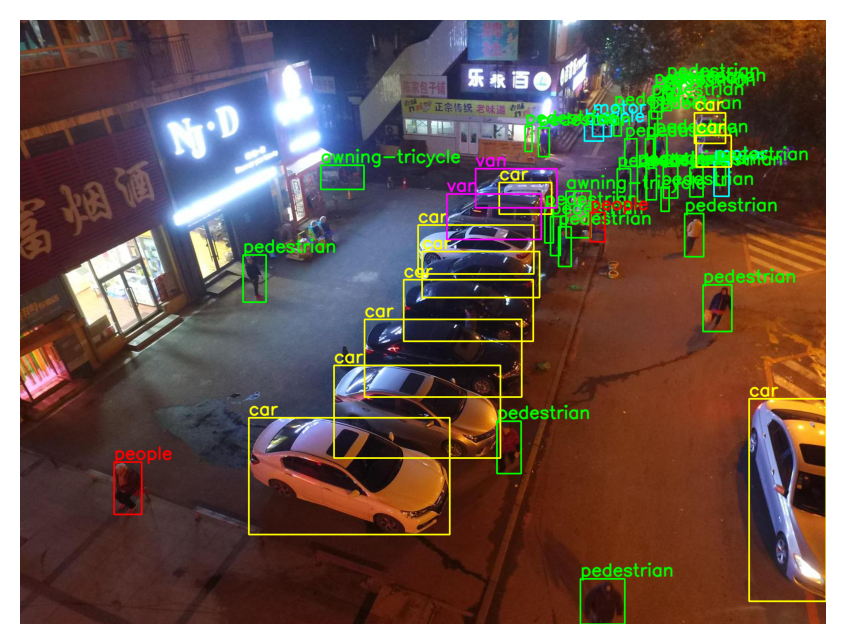

In [5]:
# Now the images and annotations need to be converted to torch.tensor objects

# put annotations from image into a tensor
# img_name without file extension
def file_to_tensor(img_path, annot_path):
    label = {
        'boxes': [],
        'labels': []
    }
    # iterate over each bounding box and add it to the tensor
    with open(annot_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            raw = line.split(',')
            # only use annotations where the ground truth
            # confidence is high (as opposed to 0)
            if int(raw[4]) == 1:
                # prep bounding box coordinates
                x1 = int(raw[0])
                y1 = int(raw[1])
                x2 = int(raw[2])
                y2 = int(raw[3])
                label_index = int(raw[5])
                label['boxes'].append([x1,y1,x2,y2])
                label['labels'].append(label_index)

    # convert arrays to tensors
    label['boxes'] = torch.tensor(label['boxes'])
    label['labels'] = torch.tensor(label['labels'])

    # load image as a tensor
    img_tensor = utils.load_img(img_path)
    return img_tensor, label

# convert all images to tensors
X_tensors = []
y_tensors = []
for i, a in zip(X_path,y_path):
    x, y = file_to_tensor(i,a)
    X_tensors.append(x)
    y_tensors.append(y)

# show first annotated image
im_np = utils.annotate_img(X_tensors[0], y_tensors[0])
#cv2.imwrite('test_annot.png',im_np)



#### 2. Holdout dataset split as specified

In [6]:
X = X_tensors#np.array(X_path)
y = y_tensors#np.array(y_path)

# Split into even 1/3 train, validation, holdout
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.3333)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.5)

#print(X_train.shape)
#print(X_valid.shape)
#print(X_hold.shape)

print(len(X_train))
print(len(X_valid))
print(len(X_hold))



166
167
167


#### 3. Correct explanation generalization from such a holdout split

The train and validation sets are used when training the retinanet model. As the model trains, predictions are made on the validation set to determine the accuracy of the network. The holdout set is used on to compare the effectiveness of final model against other models.

#### 4. Printout of dataset distribution, including missing data. For imagery datasets, provide the "average image" for each class. For tabular data, use `value_counts()` and `describe()`. For textual data, show the distribution of your labels/targets.

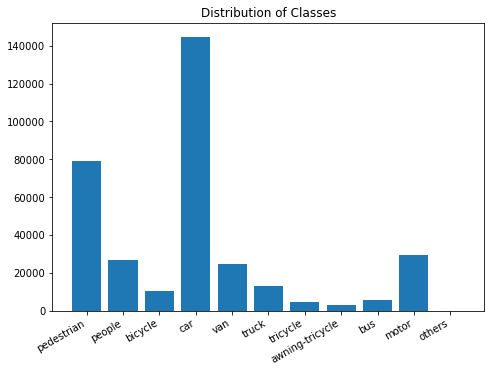

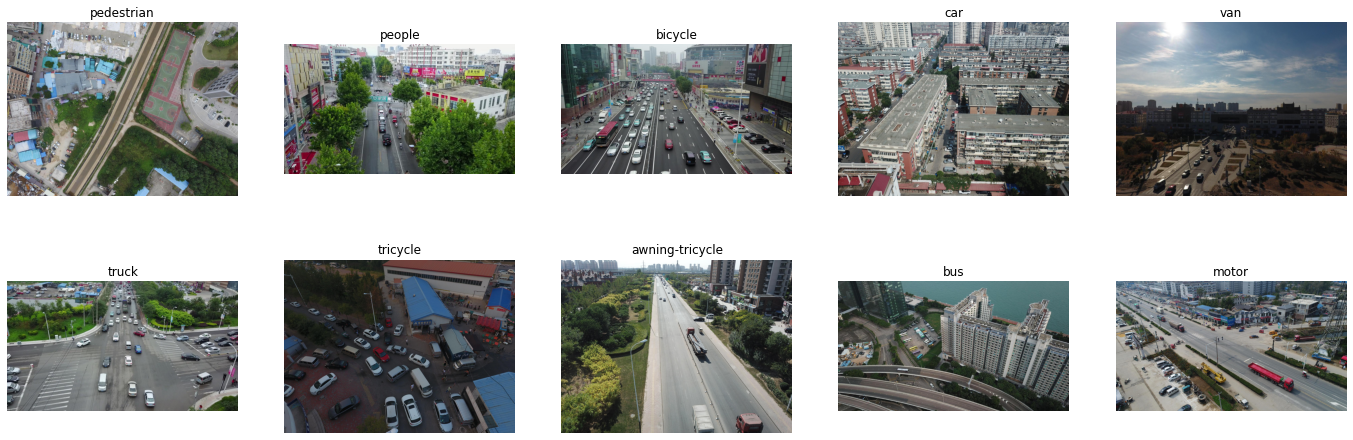

In [10]:
# The annotation file contains an index of bounding boxes and labels for all images
df_labels = pd.read_csv('visDrone_train_annotations.csv')

label_dict = {1: 'pedestrian',
              2: 'people',
              3: 'bicycle',
              4: 'car',
              5: 'van',
              6: 'truck',
              7: 'tricycle',
              8: 'awning-tricycle',
              9: 'bus',
              10: 'motor',
              11: 'others'
              }

labels = list(label_dict.values())

label_dist = {}
for label in labels:
    label_dist[label] = len(df_labels[df_labels['label'] == label])

# show a bar graph of distributions of classes
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(label_dist.keys(),label_dist.values())
plt.title('Distribution of Classes')
plt.xticks(rotation=30, ha='right')
plt.show()

rand_labels = []
# show a random image that contains a label of each class
for i,label in enumerate(labels):
    df_label = df_labels[df_labels['label'] == label]
    if len(df_label) > 0:
        rand_label = np.random.randint(0,label_dist[label],1)[0]
        img_name = df_label['img_path'].iloc[rand_label]
        img_path = os.path.join(dataset_dir, img_name)
        rand_labels.append(img_path)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig = plt.figure(num=1, figsize=(24, 8))
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        title = '{}'.format(label)
        plt.title(title)
        plt.imshow(img)



#### 5. Discussion of how the dataset distribution can/will affect your modeling.

There is a pretty substantial class imbalance. There are many pedestrian and car instances, so the model will be accurate when identifying them, but other classes, like awning-tricycle, might not be detected since there are a lot fewer of them for the model to train on.

#### 6. Handle any missing data. For imagery/text datasets, discuss what records/items you might drop and why.

The Retinanet model takes as inputs images and annotations when it is training. Both images and annotations can have issues. I will keep all images for now, and instead focus on getting clean annotations. The dataset lists several parameters for each image annotation. [Info from here](https://github.com/dronefreak/VisDrone-dataset-python-toolkit)

| Parameter       | Description                                                                  |
|-----------------|------------------------------------------------------------------------------|
| bbox_left       | x coordinate of top-left corner of predicted bounding box                    |
| bbox_top        | The y coordinate of the top-left corner of the predicted object bounding box |
| bbox_width      | The width in pixels of the predicted object bounding box                     |
| score           | The confidence of the ground truth bounding box instance 0 or 1              |
| object_category | Type of the annotated object 0-11                                            |
| truncation      | Indicates the degree of which the object appears outside image frame 0 or 1  |
| occlusion       | Indicates the fraction of object being occluded 0, 1, or 2                   |


Bounding boxes around objects that are occluded may be hard for the object to identify, same with truncation. Removing these from the dataset would likely improve accuracy of the model. However, the model would not perform well in the real world where objects may be naturally truncated or occluded. Therefore, it is best to leave the truncated and occluded bounding boxes in the dataset to have the model generalize well in real world environments.

The only bounding boxes I would drop are records who have a score == 0, since they have a low ground truth confidence.



#### 7. The holdout dataset also contains missing data/bad images/text. Discuss how you handled this in your holdout, or why it was not a problem for you.

The holdout dataset was not a problem for me, since I preprocess the data before splitting it into training, validation, and holdout. Any bounding box annotation where the ground truth is 1 will be used, and any with 0 will be ignored.

#### 8. Discuss (and implement if applicable) whether or not you need to scale/normalize your features, and which ones, if any, for tabular data or imagery. For textual data, display the outputs of the word embeddings and discuss why they look the way they do.

I will not need to scale or normalize features. The input to the Retinanet model is an image. The size or colors of the image do not need to be modified before being passed through the model. From what I've seen, most CNNs do not preprocess the images.

#### 9. If your dataset has categorical features: discuss and implement if you will encode them as ordinal numbers, or one-hot encode them, and why you chose to do so for each such feature. If you are using images/text, discuss whether you are performing classification or regression on your dataset and why (instead of the other one).

The labels of each bounding box are encoded as ordinal numbers. They are labeled in the dataset with the following numbering scheme:
```
label_dict = {1: 'pedestrian',
              2: 'people',
              3: 'bicycle',
              4: 'car',
              5: 'van',
              6: 'truck',
              7: 'tricycle',
              8: 'awning-tricycle',
              9: 'bus',
              10: 'motor',
              11: 'others'
              }
```
While I could one-hot encode the labels, the Retinanet model implemented in Pytorch outputs a tensor with ordinal labels (corresponding to the training set). Since this is how the model works internally, I will keep the labels as ordinal.


#### 10. Give an example of an ordinal feature that you've seen used by others, when it should have been treated as a categorical.
A model that tries to predict a persons favorite color based on the ice cream flavors they like. If the ice cream was one ordinal feature, then it might be encoded as 1: strawberry, 2: vanilla, 3: chocolate, ... This encoding is not good because there is no relationship between the value the flavor is assigned and the flavor itself. It would be better to one hot encode the flavors. E.g. (0, 1, 0) for vanilla.

#### 11. For tabular data: Use a heatmap to show the correlation between all feature pairs. Discuss, if any, which features you would recommend dropping from your model. Also discuss why you would want to drop them (what is the expected benefit?). For imagery/text: Show a histogram of the distribution of pixels or word embeddings across your dataset.

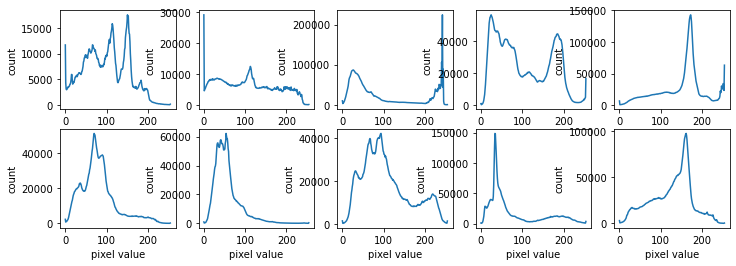

In [8]:
# show a histogram for each of the random labels of each class

for i, img_path in enumerate(rand_labels):
    fig = plt.figure(num=1, figsize=(12, 4))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # draw the corresponding histogram
    plt.subplot(2, 5, i+1)
    histogram, bin_edges = np.histogram(img, bins=256)
    plt.xlabel("pixel value")
    plt.ylabel("count")
    plt.plot(bin_edges[0:256], histogram)




#### 12. Discuss what feature you would engineer (and implement) if using tabular data, what customized dataset augmentation you would use (not required to implement) if images, or what non-standard pre-processing might help, if text

Some dataset augmentation for the dataset images include image flipping, rotations, scaling, and cropping. Since the images are taken from a high angle, I think horizontal flipping, scaling, and cropping would make for the most realistic data augmentation.

#### 13. Separate your training data into features and labels.
The training data is already split into features (the images) and labels (the annotations).

In [9]:
print("Features:")
print(X_train[0])
print("Labels:")
print(y_train[0])

Features:
tensor([[[ 85.,  86.,  66.,  ...,  53.,  52.,  55.],
         [ 53.,  56.,  59.,  ...,  56.,  56.,  54.],
         [ 56.,  56.,  52.,  ...,  64.,  69.,  60.],
         ...,
         [ 38.,  32.,  25.,  ...,  41.,  43.,  44.],
         [ 57.,  59.,  59.,  ...,  91.,  79.,  82.],
         [ 90.,  73.,  76.,  ...,  28.,  22.,  21.]],

        [[ 31.,  25.,  23.,  ...,  39.,  41.,  42.],
         [ 55.,  57.,  57.,  ...,  92.,  80.,  83.],
         [ 91.,  75.,  78.,  ...,  27.,  21.,  20.],
         ...,
         [ 93.,  74.,  63.,  ...,  27.,  27.,  34.],
         [ 37.,  35.,  49.,  ...,  35.,  39.,  40.],
         [134.,  85.,  47.,  ...,  76., 125., 112.]],

        [[ 86., 112., 101.,  ...,  28.,  28.,  30.],
         [ 32.,  32.,  48.,  ...,  36.,  40.,  41.],
         [ 72.,  19.,   0.,  ..., 104., 132., 119.],
         ...,
         [ 15.,  13.,  13.,  ..., 102.,  95.,  99.],
         [104.,  96., 100.,  ...,  79.,  80.,  77.],
         [ 81.,  82.,  75.,  ...,  36.,  34

#### 14. Discuss and implement how you will handle any dataset imbalance.

The high category imbalance of the dataset makes it difficult to identify the less common vehicles. Of the 10 categories, I think pedestrians and cars are most important, since they are also the most common objects in urban environments. Therefore, I do not think it is as important to get high accuracy on the less common vehicles like awning-tricycles.

A related issue is the high category imbalance between background and foreground objects. Since the detected object make up only a small fraction of the image (especially from high altitude images), there are many more background instances than objects. These background instances can overpower the loss function and prevent the model from learning from the foreground objects.

[Retinanet](https://arxiv.org/pdf/1708.02002.pdf) solves this issue by introducing a novel loss, dubbed Focal loss, which adds a factor to the standard cross entropy loss. The factor reduces the relative loss for well-classified examples and puts more focus on hard, misclassified examples. The original paper achieved a highly accurate object detector in the presence of vast numbers of easy background examples.

![loss function](focal_loss.png)